# <Chapter 05> 데이터 분석 종합 예제

### [5.1 중고나라 휴대폰 거래가격 예측하기]

- [<Step1. 탐색적 분석> : 중고나라 데이터 분석](#<Step1.-탐색적-분석>-:-중고나라-데이터-분석)
    - [중고나라 데이터셋 살펴보기]
    - [개별 피처 탐색하기]
    - [Random forest regressor를 이용한 가격 예측]
- [<Step2. 피처 엔지니어링> : 예측 모델 개선](#<Step2.-피처-엔지니어링>-:-예측-모델-개선)
    - [기존 feature의 가공]
- [<Step3. 예측> : 중고폰 거래가 예측](#<Step3.-예측>-:-중고폰-거래가-예측)
    - [Random forest regressor 재학습]
    - [최적의 모델 파라미터 찾기]
- [<Step4. 프로토타입> : 얼마고(Almhago?)](#<Step4.-프로토타입>-:-얼마고(Almhago?))
    - [재사용을 위한 파일 저장]
    - [가격 예측 프로그램 만들기]

-----

### <step 1> 탐색적 분석 : 중고나라 데이터 분석하기

- create_date : 판매(혹은 구매) 게시글이 올라온 시점
- price : 게시글 작성자가 제안한 휴대폰의 거래가격
- text : 게시글의 제목과 본문을 합친 텍스트 데이터
- phone_model : 휴대폰 기종
- factory_pice : 휴대폰 공시가격
- maker : 휴대폰 제조사
- price_index : 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### [중고나라 데이터셋 살펴보기]

In [2]:
# 중고나라 데이터 셋 살펴보기
df= pd.read_csv("../python-data-analysis-master/data/used_mobile_phone.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None
               create_date     price  \
0   2017-03-19  4 35 00 PM  550000.0   
1  2016-10-26  12 08 00 PM  380000.0   
2  2016-10-25  12 52 00 PM  300000.0   
3  2017-03-23  11 14 00 PM  290000.0   
4   2016-04-11  7 35 00 PM  280000.0   

                                                text          phone_model  \
0  아이폰6플러스 블랙+애플라이트 64기가 팝니다  아이폰6플러스 블랙+애플라이트 64...        iphone 6 64gb   
1  갤럭시s6엣지 32기가 팝니다 직거래  갤럭시s6엣지 3

-----


In [3]:
# 개별 피처 탐색하기 : date 피처 탐색
# create_date로 부터 '월'을 의미하는 month 정보를 치퍼로 추출합니다(람다).
df['month']=df['create_date'].apply(lambda x: x[:7]) 

# 월별 거래 횟수를 계산하여 출력합니다.
print(df['month'].value_counts())

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64


-----

### [개별 피처 탐색하기 : date 피처 탐색] 

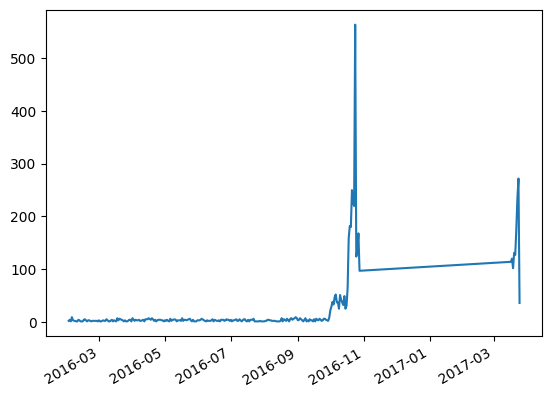

In [4]:
# 개별 피처 탐색하기 : date 피처 탐색 
# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

### [개별 피처 탐색학: price 피처 탐색]

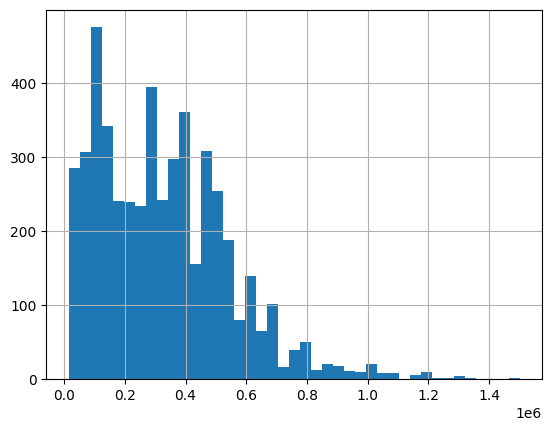

In [5]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")
plt.show()

### [개별 피처 탐색하기 : price 피처 탐색]

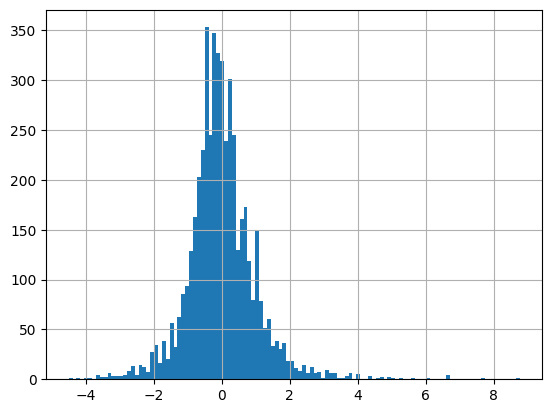

In [6]:
 # 휴대폰 기종(phone_model)별 가격의 평균과 표준편차를 계산합니다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종별 평균에
# 비해 어느 정도로 높거나 늦은지를 알 수 있게 하는 점수입니다.
df_price_model_z_score=(df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins='auto')
plt.show()

-----

### [개별 피처 탐색하기 : factory_price 피처 탐색]

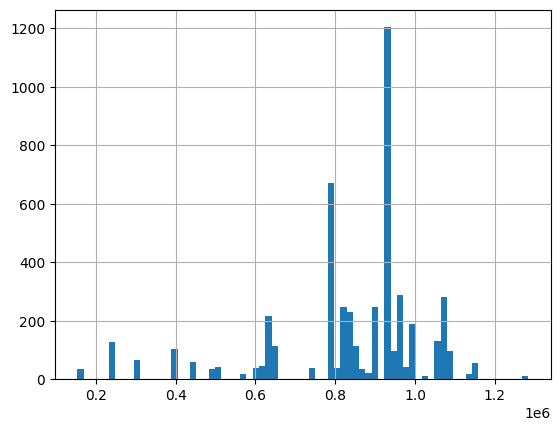

In [8]:
# factory_price 피처의 분포를 탐색합니다.
df['factory_price'].hist(bins='auto')
plt.show()


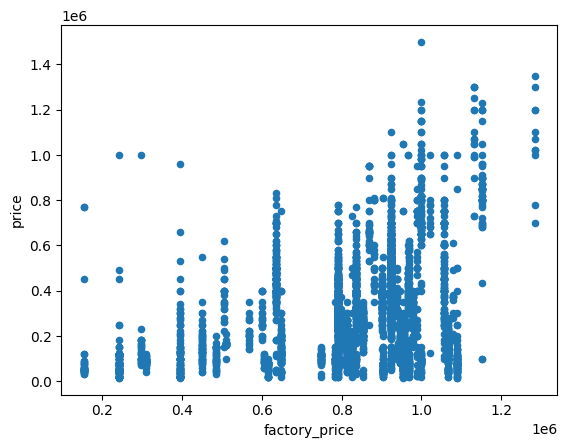

In [9]:
# factory_price 와 price 피처를 산점도 그래츠로 출력하여 상관 관게를 살펴봅니다.
df.plot.scatter(x='factory_price',y='price')
plt.show()

### [개별 피처 탐색하기 : phone_model 피처 탐색]

In [10]:
# 기종별 총 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x20be54af550>,
 'caps': [<matplotlib.lines.Line2D at 0x20be54af910>,
 'boxes': [<matplotlib.lines.Line2D at 0x20be54af2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x20be54afd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x20be54affd0>],
 'means': []}

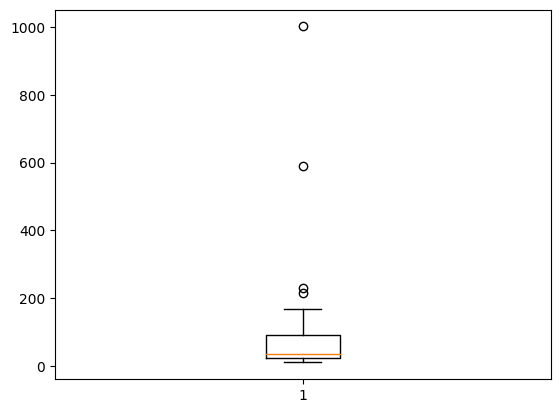

In [11]:
# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)